# Preprocessor & batching logic

This example assumes you've read `advanced.ipynb`, and covers:

  - Creating custom `Preprocessor`
  - How train & val loop and `DataGenerator` logic can be changed via `Preprocessor`

In [1]:
import deeptrain
deeptrain.util.misc.append_examples_dir_to_sys_path()

from utils import make_autoencoder, init_session, AE_CONFIGS as C
from deeptrain.util.preprocessors import Preprocessor
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'  # greatly improve display quality

Preprocessor communicates with DataGenerator twofold:
 - .process() is called in DataGenerator.get()
 - DataGenerator sets and gets following attributes *through* Preprocessor:
   - `batch_exhausted`, `batch_loaded`, `slices_per_batch`, `slice_idx`
 - Thus, Preprocessor can dictate train & validation loop logic by specifying
   when a batch ends (setting `batch_exhausted`) in `.process()`, when
   some condition holds

## RandCropPreprocessor

Below preprocessor randomly crops images to a predefined width & height,
as an example of `.process()` in action. A better example of Preprocessor
communicating with DataGenerator is the builtin
`deeptrain.util.preprocessors.TimeseriesPreprocessor`, demonstrated in
`examples/misc/timeseries`.

In [3]:
class RandCropPreprocessor(Preprocessor):
    """2D random crop. MNIST is 28x28, we try 25x25 crops,
    e.g. batch[2:27, 3:28]."""
    def __init__(self, size, crop_batch=True, crop_labels=False,
                 crop_same=False):
        # length          -> (length, length)
        # (width, height) -> (width, height)
        assert isinstance(size, (tuple, int))
        self.size = size if isinstance(size, tuple) else (size, size)

        self.crop_batch = crop_batch
        self.crop_labels = crop_labels
        self.crop_same = crop_same

    def process(self, batch, labels):
        if self.crop_batch:
            (x_start, x_end), (y_start, y_end) = self._make_crop_mask(batch)
            batch = batch[:, x_start:x_end, y_start:y_end]
        if self.crop_labels:
            if not self.crop_same or not self.crop_batch:
                (x_start, x_end), (y_start, y_end
                                   ) = self._make_crop_mask(labels)
            labels = labels[:, x_start:x_end, y_start:y_end]
        return batch, labels

    def _make_crop_mask(self, data):
        _, w, h, *_ = data.shape  # (samples, width, height, channels)
        x_offset = np.random.randint(0, w - self.size[0])
        y_offset = np.random.randint(0, h - self.size[1])
        x_start, x_end = x_offset, x_offset + self.size[0]
        y_start, y_end = y_offset, y_offset + self.size[1]
        return (x_start, x_end), (y_start, y_end)

In [4]:
C['datagen'    ]['preprocessor'] = RandCropPreprocessor(size=24)
C['val_datagen']['preprocessor'] = RandCropPreprocessor(size=24)
C['datagen'    ]['batch_size'] = 128
C['val_datagen']['batch_size'] = 128
C['model']['batch_shape'] = (128, 24, 24, 1)
C['traingen']['iter_verbosity'] = 0
C['traingen']['epochs'] = 1

In [5]:
tg = init_session(C, make_autoencoder)

Discovered 48 files with matching format
48 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated

Discovered 36 files with matching format
36 set nums inferred; if more are expected, ensure file names contain a common substring w/ a number (e.g. 'train1.npy', 'train2.npy', etc)
DataGenerator initiated

NOTE: will exclude `labels` from saving when `input_as_labels=True`; to keep 'labels', add '{labels}'to `saveskip_list` instead
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 48 files with matching format
................................................ finished, w/ 6144 total samples
Train initial data prepared
Preloading superbatch ... WARNING: multiple file extensions found in `path`; only .npy will be used 
Discovered 36 files with matching format
.................................... finished, w/ 4608 total sample


Data set_nums shuffled


_____________________
 EPOCH 1 -- COMPLETE 



Validating...
TrainGenerator state saved
Model report generated and saved
Best model saved to C:\Users\OverL\Desktop\School\Deep Learning\DL_Code\dev_tg\examples\dir\outputs\models\M8__model-nadam__min.148
TrainGenerator state saved
Model report generated and saved


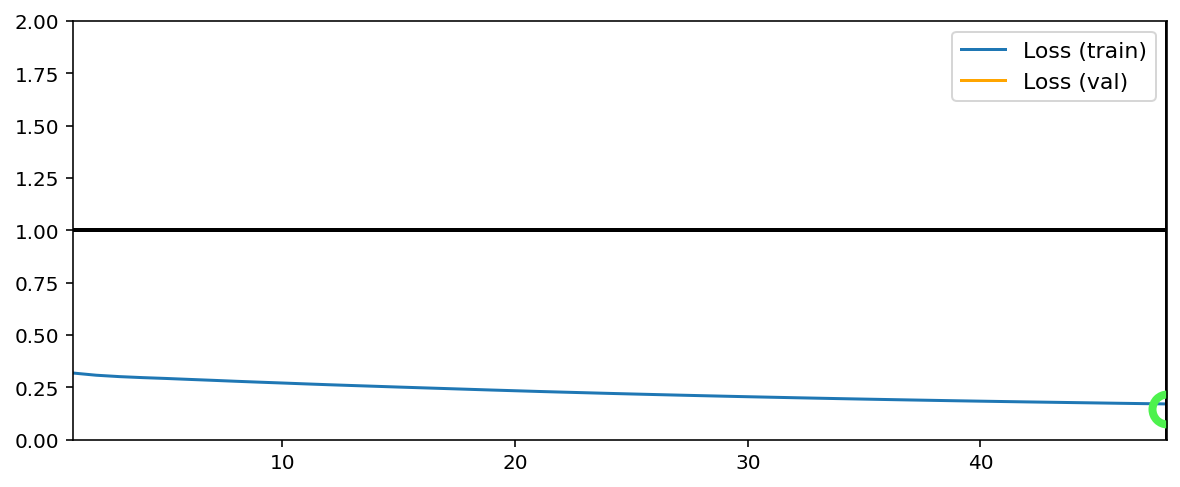

Training has concluded.


In [6]:
tg.train()

## TimeseriesPreprocessor

A better example of `Preprocessor` communicating with `DataGenerator` is the builtin `deeptrain.util.preprocessors.TimeseriesPreprocessor`, demonstrated in `examples/misc/timeseries`. 
Its main logic methods are worth inspecting.

`.process()` checks if we're at the first slice (window), and sets the window sequence length and number of windows per batch accordingly. This enables having variable windows per batch.

In [7]:
from deeptrain.util.preprocessors import TimeseriesPreprocessor
from inspect import getsource
print(getsource(TimeseriesPreprocessor.process))

    def process(self, batch, labels):
        """Return next `batch` window, and unchanged `labels`."""
        if self.slice_idx == 0:
            # ensure number of windows accurate for every new batch
            self._batch_timesteps = batch.shape[1]
            self._set_slices_per_batch()
        return self._next_window(batch), labels



`._next_window()` fetches next window in the sequence according to `slice_idx`, `window_size`, and two other attrs (see docs)

In [8]:
print(getsource(TimeseriesPreprocessor._next_window))

    def _next_window(self, batch):
        """Fetches temporal slice according to `window_size`, `slide_size`,
        `start_increment`, and `slice_idx`;
        See :class:`TimeseriesPreprocessor` for examples."""
        start = self.slice_idx * self.slide_size + self.start_increment
        end   = start + self.window_size
        return batch[:, start:end]



Lastly, it tells `DataGenerator` that batch ends when the last window was processed:

In [9]:
print(getsource(TimeseriesPreprocessor.update_state))  # called within DataGenerator.update_state

    def update_state(self):
        """Increment `slice_idx` by 1; if `slice_idx == slices_per_batch`,
        set `batch_exhausted = True`, `batch_loaded = False`.
        """
        self.slice_idx += 1
        if self.slice_idx == self.slices_per_batch:
            self.batch_exhausted = True
            self.batch_loaded = False

